In [2]:
from collections import deque
from itertools import chain
import heapq as hq
import numpy as np

rng = np.random.default_rng(seed=42)

class Trade: 
    def __init__(self, bid_order, ask_order, price, volume):
        self.bid_order = bid_order
        self.ask_order = ask_order
        self.price = price
        self.volume = volume
    
    def __repr__(self):
        return f"Trade(bid_id={self.bid_order.id}, ask_id={self.ask_order.id}, price={self.price}, volume={self.volume})"
    
class Order: 
    _id_counter = 0 

    def __init__(self, price=None, volume=100, is_bid=True, is_market=False, trader_id=None, lifetime=None):
        self.price = price 
        self.volume = volume 
        self.is_bid = is_bid
        self.id = Order._id_counter
        self.is_market = is_market
        self.trader_id = trader_id
        self.lifetime = lifetime

        Order._id_counter += 1
    
    def __repr__(self):
        side = "BID" if self.is_bid else "ASK"
        type_ = "MARKET" if self.is_market else "LIMIT"
        return f"Order(id={self.id}, price={self.price}, volume={self.volume}, side={side}, type={type_}, trader_id={self.trader_id})"
    
class MarketOrder(Order):

    def __init__(self, volume=100, is_bid=True, trader_id=None):
        price = float('inf') if is_bid else -float('inf')
        super().__init__(price, volume, is_bid, is_market=True, trader_id=trader_id)



In [3]:
class ExpirationWheel:
    def __init__(self, min_lifetime, max_lifetime):
        self.max_lifetime = max_lifetime
        self.min_lifetime = min_lifetime
        self.expiration_bucket = [[] for _ in range(max_lifetime)]
        self.now = 0

    def schedule(self, order):
        lifetime = order.lifetime if order.lifetime is not None else self.min_lifetime
        expiration = (self.now + lifetime) % self.max_lifetime
        self.expiration_bucket[expiration].append(order.id)

    def advance(self):
        self.now = (self.now + 1) % self.max_lifetime
        expired = self.expiration_bucket[self.now]
        self.expiration_bucket[self.now] = []
        return expired

In [4]:
class PriceLevel:
    def __init__(self, price):
        self.price = price 
        self.orders = deque()
    
    def add(self, order):
        self.orders.append(order)

    def top(self):
        if not self.orders:
            return None
        return self.orders[0] # O(1)

    def pop(self):
        if not self.orders:
            raise IndexError("Price level is empty.")
        return self.orders.popleft() # O(1)
    
    def fill(self, order):
        trades = []
        level_orders_filled = []
        is_bid = order.is_bid

        while not self.is_empty() and order.volume > 0: 
            top_order = self.top()
            trade_volume = 0

            if top_order.volume > order.volume: 
                trade_volume += order.volume

            elif top_order.volume == order.volume: 
                trade_volume += order.volume
                level_orders_filled.append(self.pop())
                
            else: 
                trade_volume += top_order.volume
                level_orders_filled.append(self.pop())

            # Update order volumes
            top_order.volume -= trade_volume 
            order.volume -= trade_volume 
            
            # Log trade
            bid = order if is_bid else top_order
            ask = top_order if is_bid else order
            trade = Trade(bid, ask, self.price, trade_volume)
            trades.append(trade)

        return trades, level_orders_filled
        
    def cancel(self, order):
        try:
            self.orders.remove(order) # O(n)
        except ValueError:
            raise ValueError("Order not found at this price level.")
        
    def is_empty(self):
        return True if len(self.orders) == 0 else False
    
    def get_stats(self):
        volume = sum(order.volume for order in self.orders)
        return {
            "price" : self.price, 
            "volume" : volume,
            "n orders" : len(self.orders)
        }
    
    def __repr__(self):
        return f"PriceLevel(price={self.price}, orders={list(self.orders)})"
    
    def __str__(self):
        volume = sum(order.volume for order in self.orders)
        return f"PriceLevel: Price={self.price}, Volume={volume}, Orders={len(self.orders)}"


In [5]:
class PriceBook:
    def __init__(self, is_bid_side):
        self.order_map = {}
        self._price_levels = {}
        self._heap = []
        self.is_bid_side = is_bid_side

    def add(self, order): 
        price = order.price

        if price not in self._price_levels:
            # Add price level to heap
            self._price_levels[price] = PriceLevel(price)
            # Use negative price for max-heap behavior on bid side.
            heap_price = -price if self.is_bid_side else price
            hq.heappush(self._heap, heap_price)

        # Add order to price level 
        self._price_levels[price].add(order)
        # Add order to the order map 
        self.order_map[order.id] = order

    
    def cancel(self, order):
        price = order.price
        if price not in self._price_levels:
            raise ValueError(f"Price {price} not found in PriceBook.")

        try:
            self._price_levels[price].cancel(order)
            # Trying to remove the price level from the heap here would be O(N) so we delay clean up
        except ValueError as e:
            # Propagate the original error
            raise ValueError(f"Failed to cancel order {order.id}: {e}") from e
        
        # Remove from order map
        del self.order_map[order.id]

    def best_price(self):
        if not self._price_levels: 
            return None
        else:
            # Since I didn't remove empty price levels upon order cancellation I have to handle it here
            while self._heap:
                best_price = - self._heap[0] if self.is_bid_side else self._heap[0]
                # Remove empty price levels
                if self._price_levels[best_price].is_empty():
                    hq.heappop(self._heap)
                    del self._price_levels[best_price]
                else: 
                    break

            if self._heap:
                return best_price
            else:
                return None
        
    def fill(self, order):
        if order.is_bid == self.is_bid_side:
            raise ValueError("Cannot fill an order on the same side of the PriceBook.")
        
        price = order.price
        trades = []
        best_price = self.best_price()

        while best_price and order.volume > 0:
            
            # Check whether prices are compatible
            can_fill = (best_price >= price) if self.is_bid_side else (best_price <= price)

            if can_fill:
                trades_at_price, orders_filled = self._price_levels[best_price].fill(order)
                trades.extend(trades_at_price)
                for o in orders_filled:
                    try:
                        del self.order_map[o.id]
                    except KeyError as e:
                        raise KeyError(f"Tried to delete order {e} from the order_map. It is probably a duplicate order.")
                    
            else:
                break
            
            # This simultaneously removes empty price levels and establishes next best_price
            best_price = self.best_price()

        # Return list of trades
        return trades
    
    def get_stats_l2(self):
        price_volume = {}
        for heap_price in sorted(self._heap, reverse= not self.is_bid_side):
            price = -heap_price if self.is_bid_side else heap_price
            price_level = self._price_levels[price]
            stats = price_level.get_stats()
            volume = stats["volume"]
            price_volume[price] = volume 

        return {
            "Side": ("Bid" if self.is_bid_side else "ASK"),
            "Price-Volume": price_volume
        }
    
    def __repr__(self):
        return f"PriceBook(is_bid_side={self.is_bid_side}, price_levels={sorted(list(self._price_levels.keys()))})"
    
    def display(self):
        print(f"{'BID' if self.is_bid_side else 'ASK'} PriceBook:")
        for heap_price in sorted(self._heap, reverse= not self.is_bid_side):
            price = -heap_price if self.is_bid_side else heap_price
            price_level = self._price_levels[price]
            print(price_level)

In [6]:
class Asset:
    def __init__(self, initial_value=100):
        self.initial_value = initial_value
        self.value = initial_value

    def evolve_value(self, drift=0, sigma=0.5):
        self.value += rng.normal(drift, sigma)

    def __repr__(self):
        return f"Asset(value={self.value})"
    
    def __str__(self):
        return f"Current Value: {self.value}, Initial Value: {self.initial_value}"
    
class TradesNotification:
    def __init__(self, order):
        self.trader_id = order.trader_id
        self.order_id = order.id
        self.is_bid = order.is_bid

        self.price_volume = {}
        self.counter_party_volume = {}
        self.num_trades = 0

        self._remaining_volume = order.volume
        self.is_filled = True if order.volume == 0 else False

    @property
    def average_price(self):
        return self.total_notional / self.total_filled_volume 
    
    @property 
    def total_filled_volume(self):
        return sum(self.price_volume.values())
    
    @property
    def total_notional(self):
        return sum(price * volume for price, volume in self.price_volume.items())

    def add_trade(self, trade):
        self.price_volume[trade.price] = self.price_volume.get(trade.price, 0) + trade.volume
        self.num_trades += 1
        if self.is_bid:
            cp_id = trade.ask_order.trader_id
        else:
            cp_id = trade.bid_order.trader_id
        self.counter_party_volume[cp_id] = self.counter_party_volume.get(cp_id, 0) + trade.volume
        return self
    
    def __repr__(self):
        status = "FILLED" if self.is_filled else "PARTIAL"
        return (f"TradesNotification(order_id={self.order_id}, "
                f"filled {self.total_filled_volume}@{self.average_price:.2f} avg, "
                f"{self.num_trades} trades, remaining={self._remaining_volume}, {status})")
    
    def __str__(self):
        status = "FILLED \u2713" if self.is_filled else "PARTIAL"
        return (f"order_id:{self.order_id}, \n"
                f"filled {self.total_filled_volume}@{self.average_price:.2f} avg, \n"
                f"{self.num_trades} trades, remaining:{self._remaining_volume}, {status}")
    

In [7]:
class OrderBook:

    def __init__(self, min_lifetime=3, max_lifetime=1000):
        self.bids = PriceBook(is_bid_side=True)
        self.asks = PriceBook(is_bid_side=False)
        self.expiration_wheel = ExpirationWheel(min_lifetime, max_lifetime)

        # Volume per trade cycle (usually a tick)
        self.volume_traded = 0 
    
    @property
    def best_bid(self):
        return self.bids.best_price()
    
    @property
    def best_ask(self):
        return self.asks.best_price()
    
    @property 
    def spread(self):
        if self.best_bid == None or self.best_ask == None:
            return None
        else: 
            return round(self.best_ask-self.best_bid, 2)
    
    @property 
    def mid_price(self):
        if self.best_bid == None or self.best_ask == None:
            return None
        else: 
            return round((self.best_ask + self.best_bid) / 2, 2)
    
    def process_orders(self, orders):
        trades = []
        for order in orders:
            if order.is_bid: 
                trades.extend(self.asks.fill(order))
            else:
                trades.extend(self.bids.fill(order))

            # Only add remaining volume to book if it is a limit order
            if order.volume and not order.is_market:
                self.expiration_wheel.schedule(order)
                if order.is_bid:
                    self.bids.add(order)
                else:
                    self.asks.add(order)
            
        return self._process_trades(trades)

    def _process_trades(self, trades):
        self.volume_traded = 0
        order_notifs = {}
        for trade in trades:
            self.volume_traded += trade.volume
            bid_trader_id = trade.bid_order.trader_id
            ask_trader_id = trade.ask_order.trader_id
            if bid_trader_id is not None:
                bid_order = trade.bid_order
                order_notifs[trade.bid_order.id] = order_notifs.get(trade.bid_order.id, TradesNotification(bid_order)).add_trade(trade)
            if ask_trader_id is not None:
                ask_order = trade.ask_order
                order_notifs[trade.ask_order.id] = order_notifs.get(trade.ask_order.id, TradesNotification(ask_order)).add_trade(trade)
        
        return order_notifs
    
    def unfilled_orders(self, trader_id):
        unfilled_asks = self.asks.order_map.values()
        unfilled_bids = self.bids.order_map.values()
        unfilled_orders = [(order.id, order.price, order.volume) for order in chain(unfilled_asks, unfilled_bids) if order.trader_id == trader_id]
        return unfilled_orders

    def process_cancellations(self, order_ids):
        for order_id in order_ids:
            if order_id in self.bids.order_map:
                order = self.bids.order_map[order_id]
                self.bids.cancel(order)
            elif order_id in self.asks.order_map:
                order = self.asks.order_map[order_id]
                self.asks.cancel(order)
            else:
                # order not on books might have been filled.
                pass
                #raise KeyError(f"Order with id {order_id} could not be found in either side of the order book.")
    
    def get_stats(self): 
        bid_l2 = self.bids.get_stats_l2() 
        ask_l2 = self.asks.get_stats_l2()
        bid_price_vol = bid_l2["Price-Volume"]
        ask_price_vol = ask_l2["Price-Volume"]
        total_bid_depth = sum(bid_price_vol.values())
        total_ask_depth = sum(ask_price_vol.values())
        trade_volume = self.volume_traded
        return {
            "Bid L2": bid_price_vol,
            "Ask L2": ask_price_vol,
            "Bid Depth": total_bid_depth,
            "Ask Depth": total_ask_depth,
            "One Tick Traded Volume": trade_volume,
        }

    
    def __repr__(self):
        return f"OrderBook(bids={self.bids.__repr__()}, asks={self.asks.__repr__()})"
    
    def display(self):
        self.bids.display()
        self.asks.display()

In [8]:
class BackgroundFlow(): 
    def __init__(self, arrival_rate=100, min_volume=10, max_volume=100, info=0.3, ag_noise = 0.1, private_info_coeff=0.8):

        self.arrival_rate = arrival_rate
        self.min_volume = min_volume
        self.max_volume = max_volume

        # Liquidity takers fraction
        self.info = info
        self.ag_noise = ag_noise
        self.pass_noise = 1 - info - ag_noise
        if self.pass_noise < 0:
            raise ValueError("Proportion of aggressive noise and info traders cannot together exceed one.")
        self.private_info_coeff = private_info_coeff
        
    def generate_orders(self, order_book, asset):
        n_orders = rng.poisson(self.arrival_rate)
        orders = []

        # Informed traders 
        if order_book.best_bid is None:
            best_bid = asset.value
        else:
            best_bid = order_book.best_bid
        
        if order_book.best_ask is None:
            best_ask = asset.value
        else:
            best_ask = order_book.best_ask
        
        mid_price = (best_bid + best_ask) / 2

        # We model three types of traders: 
        # - aggressive informed traders (take liquidity in direction of fundamental value)
        # - aggressive noise traders (take liquidity randomly - exogenous reasons)
        # - passive noise traders (provide liquidity randomly - exogenous reasons)
        #   - passive noise traders post limit orders randomly around the mid-price with offset based on spread.
        
        for _ in range(n_orders):
            
            volume = rng.integers(self.min_volume, self.max_volume + 1)
            trader = rng.choice(['info', 'ag_noise', 'pass_noise'], p=[self.info, self.ag_noise, self.pass_noise])

            if trader == 'info':
                # Informed trader
                if asset.value >= mid_price:
                    is_bid = rng.random() < 0.5 + self.private_info_coeff / 2
                else:
                    is_bid = rng.random() >= 0.5 + self.private_info_coeff / 2

                orders.append(MarketOrder(volume, is_bid, 0))

            elif trader == 'ag_noise':
                # Aggressive noise trader
                is_bid = rng.random() < 0.5
                orders.append(MarketOrder(volume, is_bid, 0))
            
            else:
                # Passive noise trader 
                is_bid = rng.random() < 0.5
                spread = max((best_ask - best_bid), 0.01)
                offset = rng.uniform(0.01, 2 * spread)
                price = mid_price - offset if is_bid else mid_price + offset
                orders.append(Order(price, volume, is_bid, False, 0, 3))
        
        return orders


In [9]:
class MarketMaker():
    def __init__(self, strategy):
        self.trader_id = 1
        self.inventory = 0
        self.cash = 0
        self.strategy = strategy

        self.buy_volume = 0 
        self.sell_volume = 0 
    
    def order_update(self, order_book):
        # Generate an order via a strategy 
        orders = self.strategy(self, order_book)
        for order in orders:
            order.trader_id = self.trader_id
        
        cancellations = [unfilled_order[0] for unfilled_order in order_book.unfilled_orders(self.trader_id)]
        
        return orders, cancellations
    
    def process_trades_notifications(self, trades_notifications):
        for trades_notification in trades_notifications:
            if trades_notification.trader_id != self.trader_id:
                raise ValueError("Notification and trader don't match.")
            if trades_notification.is_bid:
                self.inventory += trades_notification.total_filled_volume
                self.cash -= trades_notification.total_notional
                self.buy_volume += (trades_notification.total_filled_volume)
            else:
                self.inventory -= trades_notification.total_filled_volume
                self.cash += trades_notification.total_notional
                self.sell_volume += (trades_notification.total_filled_volume)
    
    def pnl(self, order_book):
        # Mark to market
        unrealised_pnl = order_book.mid_price * self.inventory if order_book.mid_price else None
        total_pnl = self.cash + unrealised_pnl if unrealised_pnl else None
        return total_pnl
    
    def get_stats(self):
        return {
            "Inventory" : self.inventory,
            "Cash" : self.cash
        }

In [10]:
class SimpleMarketMakingStrategy:
    def __init__(self, spread, size, inventory_limit):
        self.size = size
        self.spread = spread
        self.inventory_limit = inventory_limit

    def __call__(self, market_maker, order_book):
        if order_book.mid_price:
            mid_price = order_book.mid_price
        else: 
            # Hard code mid_price (maybe change)
            mid_price = 100
        
        orders = [] 
        if market_maker.inventory <= self.inventory_limit:
            orders.append(Order(mid_price - self.spread / 2, self.size, True, False))
        if market_maker.inventory >= -self.inventory_limit:
            orders.append(Order(mid_price + self.spread / 2, self.size, False, False))

        return orders

         41379679 function calls in 21.504 seconds

   Ordered by: cumulative time
   List reduced from 86 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   21.504   10.752 /Users/sebastianodutola/.virtualenvs/LOB/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3663(run_code)
        2    0.000    0.000   21.504   10.752 {built-in method builtins.exec}
        1    0.241    0.241   21.504   21.504 /var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_60023/299416847.py:20(simulate)
    10000    8.561    0.001    9.650    0.001 /var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_60023/26522162.py:16(generate_orders)
    10000    0.642    0.000    8.597    0.001 /var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_60023/1446298081.py:33(process_orders)
  1016050    0.852    0.000    3.921    0.000 /var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_60023/4030748016.py

/var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_60023/299416847.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


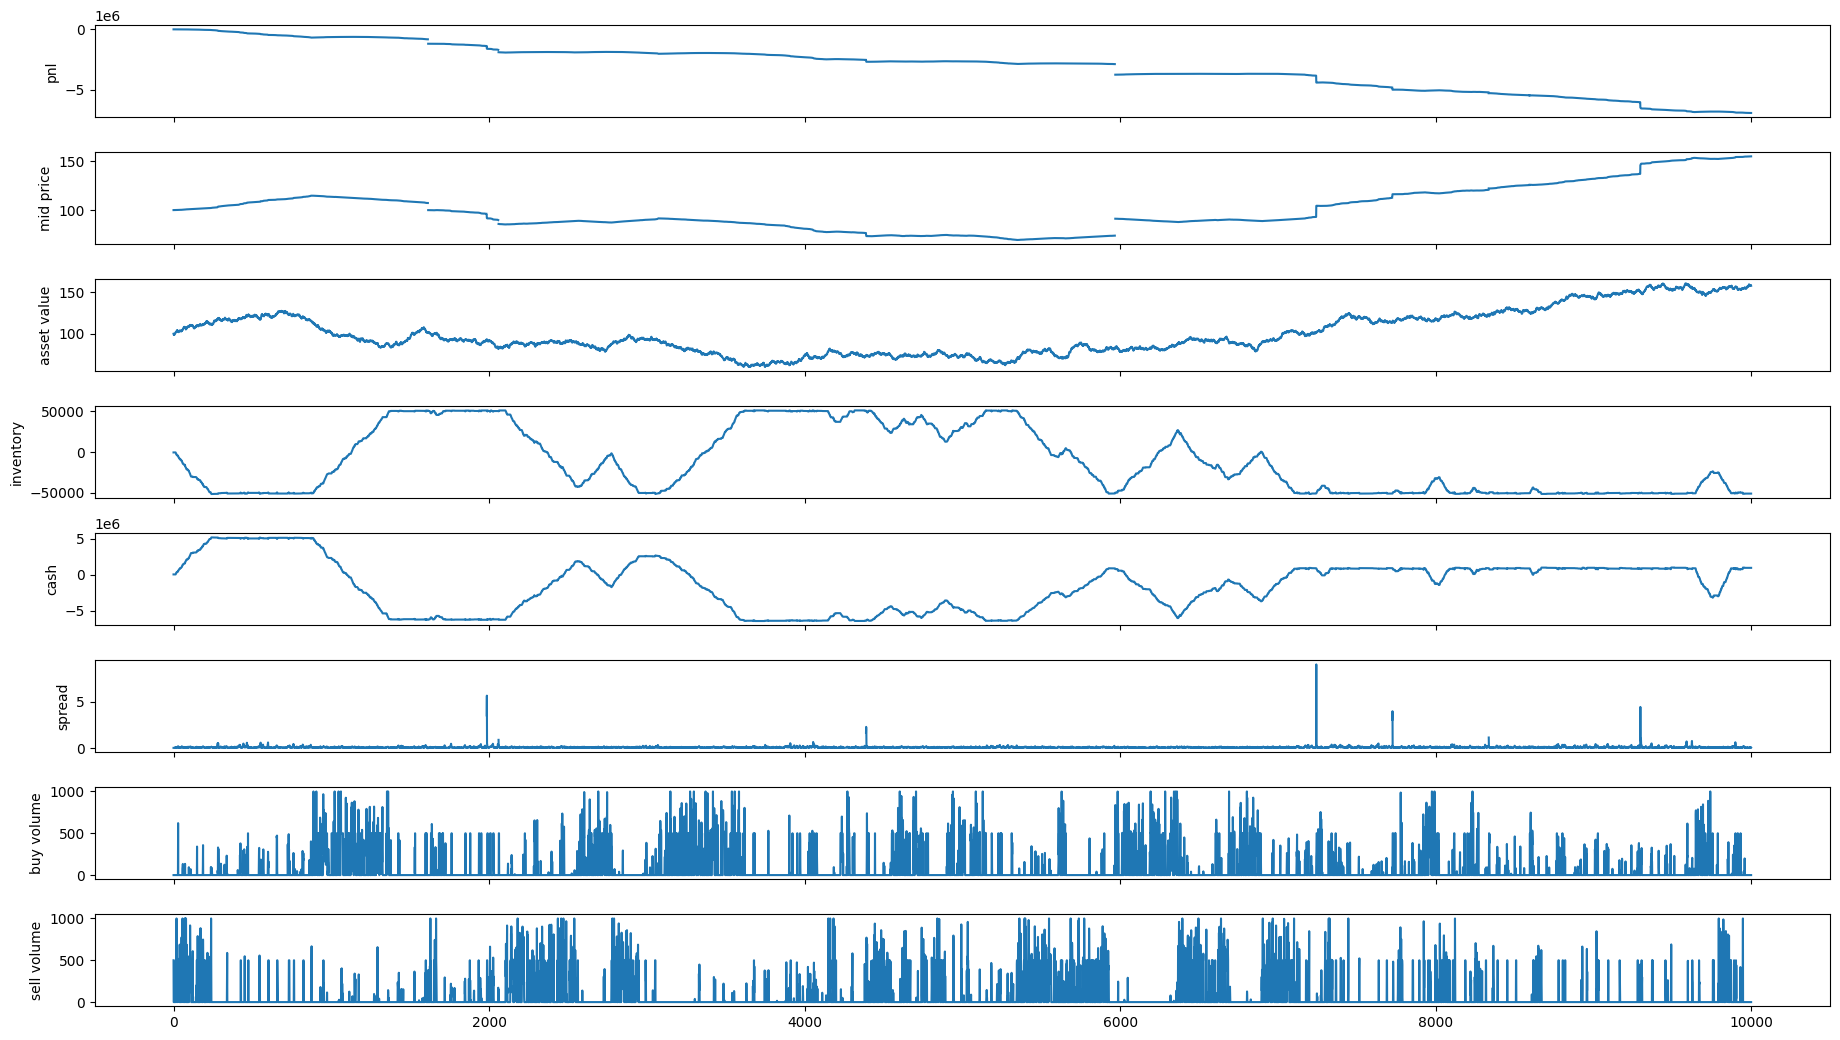

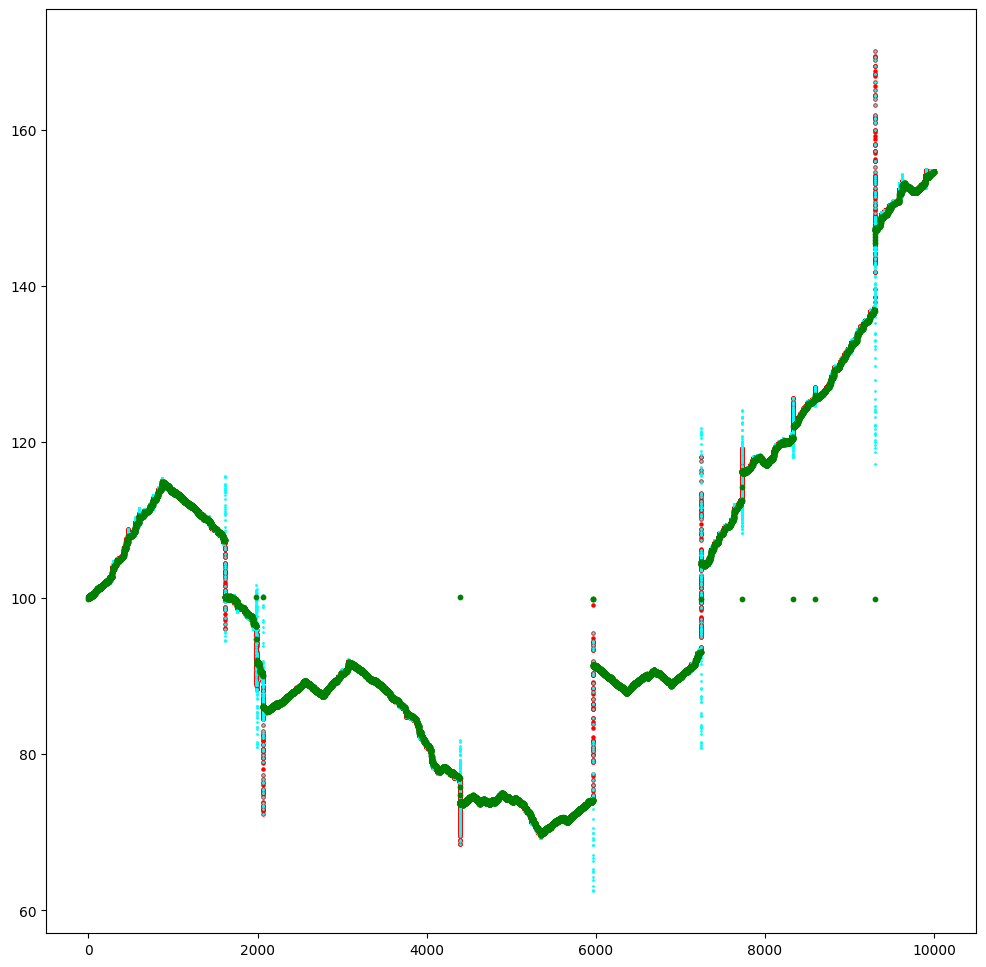

In [11]:
import matplotlib.pyplot as plt
import cProfile 
import pstats

rng = np.random.default_rng(seed=42)
s = Asset()
ob = OrderBook()

mmStrat = SimpleMarketMakingStrategy(0.2, 500, 50000)
mm = MarketMaker(mmStrat)
bf = BackgroundFlow(info=0.2, ag_noise=0.15)

timesteps = 10000

# Visualise orders 
mm_orders = []
noise_orders = []
trade_prices = []

def simulate(mm, bf, ob, timesteps, asset):
    trackers = {
    "pnl" : np.zeros(timesteps),
    "mid price": np.zeros(timesteps),
    "asset value": np.zeros(timesteps),
    "inventory" : np.zeros(timesteps),
    "cash" : np.zeros(timesteps),
    # "ask depth": np.zeros(timesteps),
    # "bid depth": np.zeros(timesteps),
    # "traded volume": np.zeros(timesteps),
    "spread": np.zeros(timesteps),
    "buy volume": np.zeros(timesteps),
    "sell volume": np.zeros(timesteps)
    }

    # cancellations are delayed. {delay: requests}
    delay = 3
    cancel_request = [[] for _ in range(delay+1)]

    for t in range(timesteps):
        # Price Moves 
        asset.evolve_value(drift=0)
        # Expiration Wheel advances
        expirations = ob.expiration_wheel.advance()
        # Expirations are processed 
        ob.process_cancellations(expirations)

        # All Actors place their orders 
        # Problem: cancellation can be shorter than shortest expiration time.
        quotes, cancellations = mm.order_update(ob)
        background_orders = bf.generate_orders(ob, asset)

        # Cancellations requested and processed
        now = t % (delay + 1)
        cancel_time = (t + delay) % (delay + 1)
        cancel_request[cancel_time] = cancellations
        ob.process_cancellations(cancel_request[now])
        cancel_request[now] = []

        # Visualise orders:
        mm_orders.append([quote.price for quote in quotes])
        noise_order_list = [order.price for order in background_orders if order.is_market == False]
        noise_orders.append(noise_order_list)

        # Orders are processed
        trades_notifs = ob.process_orders(chain(background_orders, quotes))
        trade_prices.append([notif.average_price for notif in trades_notifs.values()])

        
        # Process trade notifications for market maker 
        mm_trades_notifs = [trades_notif for _, trades_notif in trades_notifs.items() if trades_notif.trader_id == 1]
        mm.process_trades_notifications(mm_trades_notifs)

        # Calculate pnl
        pnl = mm.pnl(ob)

        # Track
        trackers["pnl"][t] = pnl
        trackers["mid price"][t] = ob.mid_price
        trackers["spread"][t] = ob.spread
        trackers["asset value"][t] = asset.value
        trackers["inventory"][t] = mm.inventory
        trackers["cash"][t] = mm.cash
        trackers["buy volume"][t] = mm.buy_volume
        trackers["sell volume"][t] = mm.sell_volume
        
        mm.buy_volume = 0 
        mm.sell_volume = 0

        # Track Order Book Stats
        # Very Slow Call 
        # ob_stats = ob.get_stats()
        # trackers["ask depth"][t] = ob_stats["Ask Depth"]
        # trackers["bid depth"][t] = ob_stats["Bid Depth"]
        # trackers["traded volume"][t] = ob_stats["One Tick Traded Volume"]
        
    return trackers#, ob_stats

pr = cProfile.Profile()
pr.enable()
trackers = simulate(mm, bf, ob, timesteps, s)
pr.disable()

ps = pstats.Stats(pr).sort_stats('cumtime')
ps.print_stats(20)

fig, axes = plt.subplots(len(trackers), sharex=True)
for i, (k, v) in enumerate(trackers.items()):
    axes[i].plot(v)
    axes[i].set_ylabel(k)
fig.set_size_inches(18.5, 10.5)
fig.tight_layout()
fig.show()

fig2, ax2 = plt.subplots()
x = [[t]*len(orders_t) for t, orders_t in enumerate(mm_orders)]
y = mm_orders 
x_flat = [p for sublist in x for p in sublist]
y_flat = [p for sublist in y for p in sublist]

x2 = [[t]*len(orders_t) for t, orders_t in enumerate(noise_orders)]
y2 = noise_orders
x2_flat = [x for sublist in x2 for x in sublist]
y2_flat = [y for sublist in y2 for y in sublist]

x3 = [[t]*len(prices) for t, prices in enumerate(trade_prices)]
y3_flat = [y for sublist in trade_prices for y in sublist]
x3_flat = [x for sublist in x3 for x in sublist]

ax2.scatter(x3_flat, y3_flat, s=5, color='red')
ax2.scatter(x2_flat, y2_flat, s=1, color='cyan')
ax2.scatter(x_flat, y_flat, s=10, color='g')

fig2.set_size_inches(12,12)



In [12]:
# Now that our market simulation is working, we try a different market making strategy to see if we can get non-negative PnLs 
class SkewMarketMakingStrategy:
    def __init__(self, spread, size, inventory_limit, skew_coefficient=1e-4):
        self.size = size
        self.spread = spread
        self.inventory_limit = inventory_limit
        self.skew_coefficient = skew_coefficient

    def __call__(self, market_maker, order_book):
        if order_book.mid_price:
            mid_price = order_book.mid_price
        else: 
            # Hard code mid_price (maybe change)
            mid_price = 100
        
        orders = [] 
        exposure = market_maker.inventory * mid_price
        skew = exposure * self.skew_coefficient
        # skew is proportional to inventory 
        if market_maker.inventory <= self.inventory_limit:
            orders.append(Order(mid_price - self.spread - skew / 2, self.size, True, False))
        if market_maker.inventory >= -self.inventory_limit:
            orders.append(Order(mid_price + self.spread - skew / 2, self.size, False, False))

        return orders

         2280194 function calls in 1.059 seconds

   Ordered by: cumulative time
   List reduced from 86 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    1.059    0.529 /Users/sebastianodutola/.virtualenvs/LOB/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3663(run_code)
        2    0.000    0.000    1.059    0.529 {built-in method builtins.exec}
        1    0.013    0.013    1.059    1.059 /var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_60023/633250297.py:16(simulate)
      500    0.423    0.001    0.479    0.001 /var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_60023/26522162.py:16(generate_orders)
      500    0.030    0.000    0.438    0.001 /var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_60023/1446298081.py:33(process_orders)
    50991    0.047    0.000    0.216    0.000 /var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_60023/4030748016.py:5

/var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_60023/633250297.py:108: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


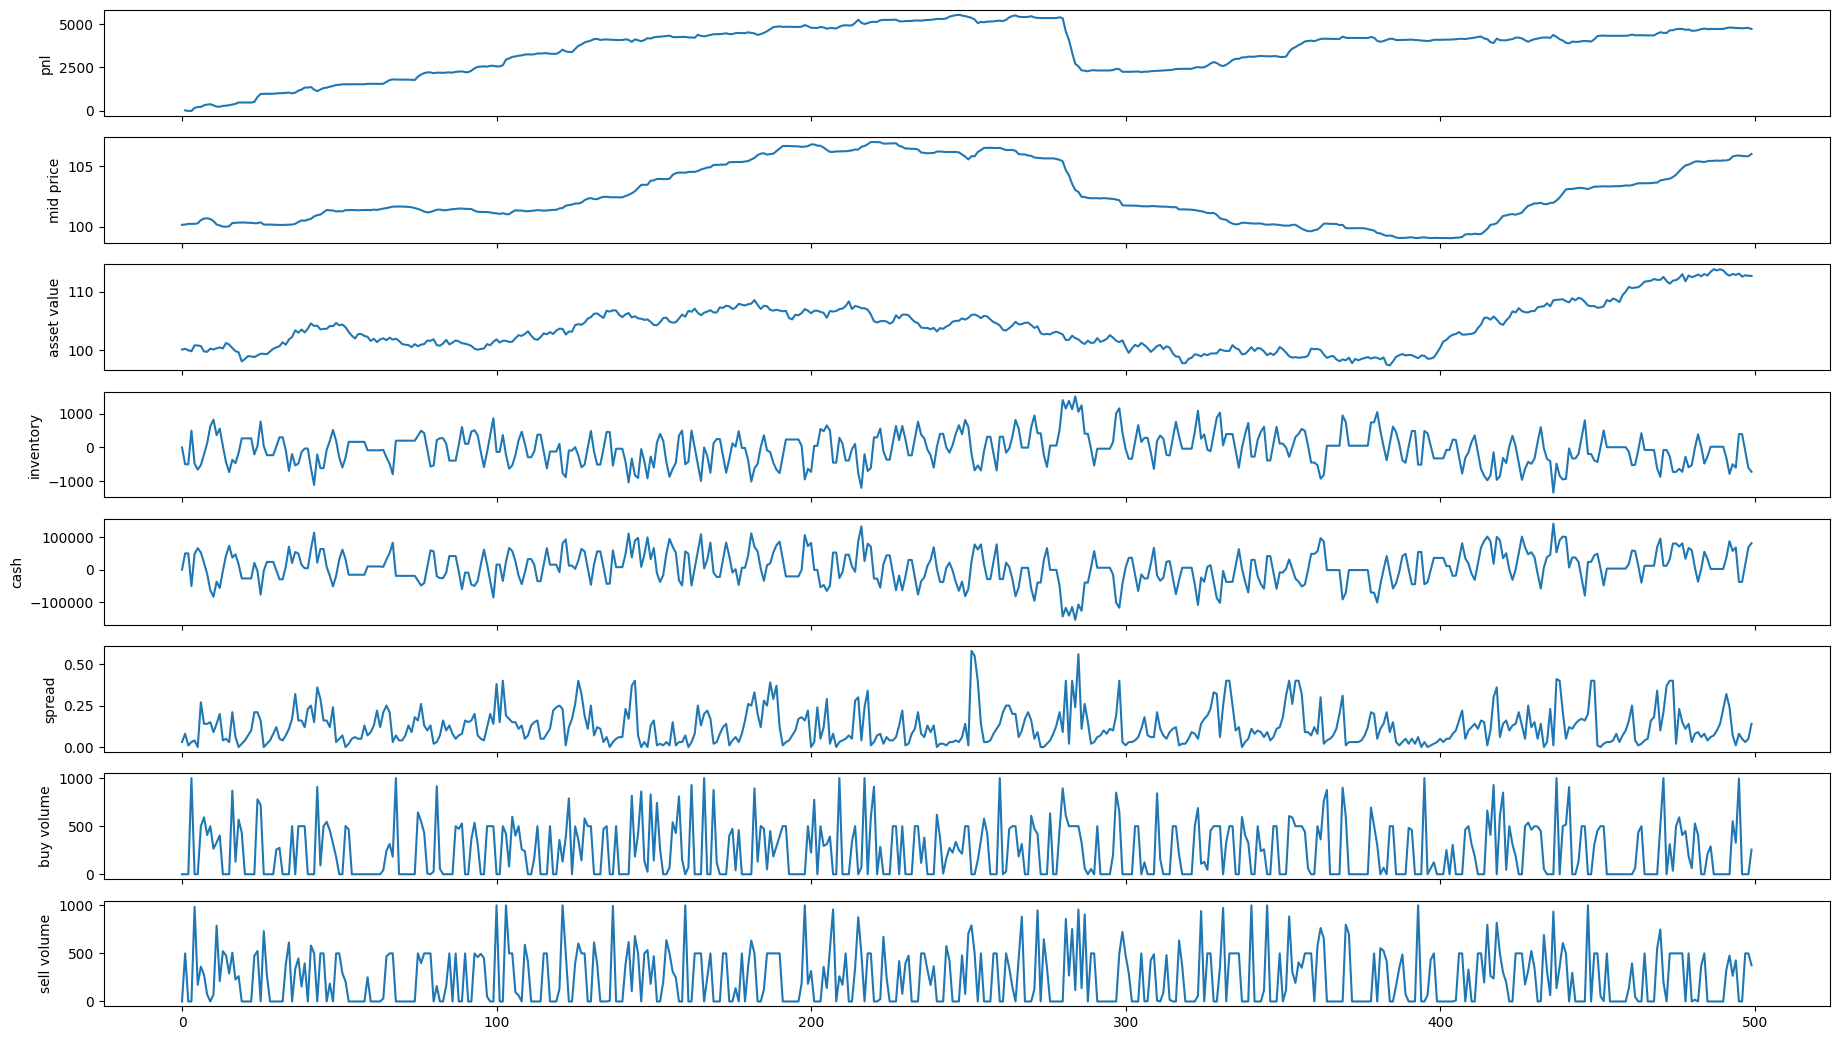

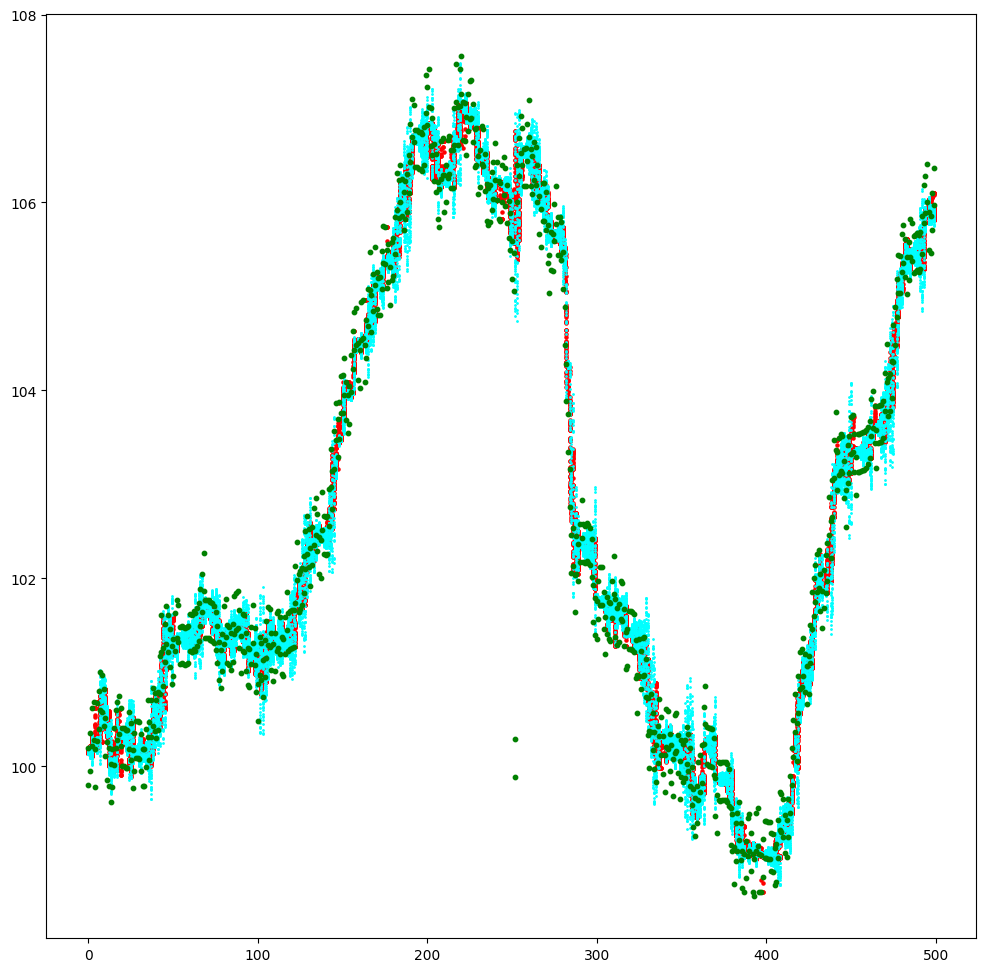

In [13]:
rng = np.random.default_rng(seed=42)
s = Asset()
ob = OrderBook()

mmStrat = SkewMarketMakingStrategy(0.2, 500, 50000, skew_coefficient=1e-5)
mm = MarketMaker(mmStrat)
bf = BackgroundFlow(info=0.3, ag_noise=0.15, private_info_coeff=0.4)

timesteps = 500

# Visualise orders 
mm_orders = []
noise_orders = []
trade_prices = []

def simulate(mm, bf, ob, timesteps, asset):
    trackers = {
    "pnl" : np.zeros(timesteps),
    "mid price": np.zeros(timesteps),
    "asset value": np.zeros(timesteps),
    "inventory" : np.zeros(timesteps),
    "cash" : np.zeros(timesteps),
    # "ask depth": np.zeros(timesteps),
    # "bid depth": np.zeros(timesteps),
    # "traded volume": np.zeros(timesteps),
    "spread": np.zeros(timesteps),
    "buy volume": np.zeros(timesteps),
    "sell volume": np.zeros(timesteps)
    }

    # cancellations are delayed. {delay: requests}
    delay = 3
    cancel_request = [[] for _ in range(delay+1)]

    for t in range(timesteps):
        # Price Moves 
        asset.evolve_value(drift=0)
        # Expiration Wheel advances
        expirations = ob.expiration_wheel.advance()
        # Expirations are processed 
        ob.process_cancellations(expirations)

        # All Actors place their orders 
        # Problem: cancellation can be shorter than shortest expiration time.
        quotes, cancellations = mm.order_update(ob)
        background_orders = bf.generate_orders(ob, asset)

        # Cancellations requested and processed
        now = t % (delay + 1)
        cancel_time = (t + delay) % (delay + 1)
        cancel_request[cancel_time] = cancellations
        ob.process_cancellations(cancel_request[now])
        cancel_request[now] = []

        # Visualise orders:
        mm_orders.append([quote.price for quote in quotes])
        noise_order_list = [order.price for order in background_orders if order.is_market == False]
        noise_orders.append(noise_order_list)

        # Orders are processed
        trades_notifs = ob.process_orders(chain(background_orders, quotes))
        trade_prices.append([notif.average_price for notif in trades_notifs.values()])

        
        # Process trade notifications for market maker 
        mm_trades_notifs = [trades_notif for _, trades_notif in trades_notifs.items() if trades_notif.trader_id == 1]
        mm.process_trades_notifications(mm_trades_notifs)

        # Calculate pnl
        pnl = mm.pnl(ob)

        # Track
        trackers["pnl"][t] = pnl
        trackers["mid price"][t] = ob.mid_price
        trackers["spread"][t] = ob.spread
        trackers["asset value"][t] = asset.value
        trackers["inventory"][t] = mm.inventory
        trackers["cash"][t] = mm.cash
        trackers["buy volume"][t] = mm.buy_volume
        trackers["sell volume"][t] = mm.sell_volume
        
        mm.buy_volume = 0 
        mm.sell_volume = 0

        # Track Order Book Stats
        # Very Slow Call 
        # ob_stats = ob.get_stats()
        # trackers["ask depth"][t] = ob_stats["Ask Depth"]
        # trackers["bid depth"][t] = ob_stats["Bid Depth"]
        # trackers["traded volume"][t] = ob_stats["One Tick Traded Volume"]
        
    return trackers#, ob_stats

pr = cProfile.Profile()
pr.enable()
trackers = simulate(mm, bf, ob, timesteps, s)
pr.disable()

ps = pstats.Stats(pr).sort_stats('cumtime')
ps.print_stats(20)

fig, axes = plt.subplots(len(trackers), sharex=True)
for i, (k, v) in enumerate(trackers.items()):
    axes[i].plot(v)
    axes[i].set_ylabel(k)
fig.set_size_inches(18.5, 10.5)
fig.tight_layout()
fig.show()

fig2, ax2 = plt.subplots()
x = [[t]*len(orders_t) for t, orders_t in enumerate(mm_orders)]
y = mm_orders 
x_flat = [p for sublist in x for p in sublist]
y_flat = [p for sublist in y for p in sublist]

x2 = [[t]*len(orders_t) for t, orders_t in enumerate(noise_orders)]
y2 = noise_orders
x2_flat = [x for sublist in x2 for x in sublist]
y2_flat = [y for sublist in y2 for y in sublist]

x3 = [[t]*len(prices) for t, prices in enumerate(trade_prices)]
y3_flat = [y for sublist in trade_prices for y in sublist]
x3_flat = [x for sublist in x3 for x in sublist]

ax2.scatter(x3_flat, y3_flat, s=5, color='red')
ax2.scatter(x2_flat, y2_flat, s=1, color='cyan')
ax2.scatter(x_flat, y_flat, s=10, color='g')

fig2.set_size_inches(12,12)

Multi-Agent Market Maker Model! 
In order to get heterogenous competitive market makers we have the following setup: 
- market makers increase spread if their PnL is negative 
- market makers skew based on exposure

In [14]:
class MarketMakerProfile: 
    def __init__(self, risk_aversion, capital=1_000_000):
        self.risk_aversion = risk_aversion
        self.capital = capital

    def get_strategy_params(self, base_spread=0.5, base_price = 100):

        # Skew Strategy has 4 params:
        # - target spread (a more risk averse actor would decrease spread)
        # - quote size (a more risk averse actor would decrease quote size)
        # - inventory limit (a more risk averse actor would have a smaller inventory limit)
        # - skew coefficient (a more risk averse actor would have a higher skew coefficient)
        # Map risk aversion ([0, 1]) to parameters
        spread = base_spread * (1 + 2 * self.risk_aversion)

        size_pct = 0.02 * (1- 0.5 * self.risk_aversion) # up to 2% of capital per quote. 
        size = (self.capital * size_pct) / base_price

        inventory_pct = 0.8 * (1 - 0.5 * self.risk_aversion) # up to 80% of capital inventory limit
        inventory_limit = (self.capital * inventory_pct)

        skew_coefficient = 1e-5 * (1 + 5 * self.risk_aversion)

        return {
            "spread": spread,
            "size": size,
            "inventory_limit": inventory_limit,
            "skew_coefficient": skew_coefficient
        }

In [169]:
class MarketMaker():
    def __init__(self, strategy):
        self.trader_id = 1
        self.inventory = 0
        self.cash = 0
        self.strategy = strategy
        self.window_size = 20
        self.pnl_history = []
        self.inventory_history = []
    
    def order_update(self, order_book):
        # Generate an order via a strategy 
        orders = self.strategy(self, order_book)
        for order in orders:
            order.trader_id = self.trader_id
        
        cancellations = [unfilled_order[0] for unfilled_order in order_book.unfilled_orders(self.trader_id)]
        
        return orders, cancellations
    
    def process_trades_notifications(self, trades_notifications):
        for trades_notification in trades_notifications:
            if trades_notification.trader_id != self.trader_id:
                raise ValueError("Notification and trader don't match.")
            if trades_notification.is_bid:
                self.inventory += trades_notification.total_filled_volume
                self.cash -= trades_notification.total_notional
            else:
                self.inventory -= trades_notification.total_filled_volume
                self.cash += trades_notification.total_notional
        
        self.inventory_history.append(self.inventory)
        if len(self.inventory_history) > self.window_size:
            self.inventory_history.pop(0)
    
    def pnl(self, mid_price):
        # Mark to market
        unrealised_pnl = mid_price * self.inventory if mid_price else 100 * self.inventory
        total_pnl = self.cash + unrealised_pnl
        return total_pnl
    
    def update_pnl_history(self, mid_price):
        pnl = self.pnl(mid_price)
        self.pnl_history.append(pnl)

        if len(self.pnl_history) > self.window_size:
            self.pnl_history.pop(0)
    
    def recent_pnl_change(self):
        return sum(self.pnl_history[-5:-1]) / 5 - sum(self.pnl_history[0:4]) / 5
    
    def recent_fill_rate(self):
        return abs(np.sum(np.array(self.inventory_history[-5:-1]) - np.array(self.inventory_history[-6:-2])) / 5)

    def get_stats(self):
        return {
            "Inventory" : self.inventory,
            "Cash" : self.cash
        }

In [209]:
class SkewMarketMakingStrategy:
    def __init__(self, size, inventory_limit, max_skew=1, base_spread=0.1, risk_aversion=0.9):
        self.size = size
        self.base_spread = base_spread
        self.inventory_limit = inventory_limit
        self.max_skew = max_skew
        self.spread = base_spread

        # Risk aversion based instance variables 

        # Target pnl:
        # Risk-Netural: $ 0.25 / tick 
        # Risk-Averse: $ 1 / tick 
        self.target_pnl = 5 * (1 + 3 * risk_aversion)

        # Adjustment speed: 
        # Risk-Netural: 5% per tick 
        # Risk-Averse: 1 % per tick
        self.adjustment_speed = 0.03 * (1 - 0.8 * risk_aversion)

        # Fill rate targets
        self.target_fill_rate = 0.1 * (1 - 0.5 * risk_aversion)

        # Bounds: 
        self.min_spread = 0.05 
        self.max_spread = 3
        self.min_fill_rate = 0.02
    
    def adjust_spread(self, market_maker):
        
        if len(market_maker.pnl_history) < 20: 
            print("history_not long enough yet")
            return
        
        # PnL consideration
        pnl_change = market_maker.recent_pnl_change()
        # Distance to target
        to_pnl_target = pnl_change - self.target_pnl
        
        # Fill rate consideration
        fill_rate = market_maker.recent_fill_rate()
        print("fill_rate: ", fill_rate)
        to_fill_target = fill_rate - self.target_fill_rate

        if fill_rate < self.min_fill_rate:
            self.spread *= (1 - self.adjustment_speed)
        elif to_pnl_target > 0: 
            # PnL is larger than target so we can narrow spreads 
            self.spread *= (1 - self.adjustment_speed)
            if self.spread < self.min_spread:
                self.spread = self.min_spread
            print(f"good PnL, spread: {self.spread}")
        elif to_pnl_target < 0:
            if self.spread > 0.1:
                self.spread *= (1 + 2 * self.adjustment_speed)
            else: 
                # If spread is very small we need a quick shock
                self.spread += self.adjustment_speed
            if self.spread > self.max_spread:
                self.spread = self.max_spread

            print(f"bad PnL, spread: {self.spread}")


    def __call__(self, market_maker, order_book):

        if order_book.mid_price:
            mid_price = order_book.mid_price
        else: 
            print("no mid_price for some reason")
            # Hard code mid_price (maybe change)
            mid_price = 100

        # Update the pnl history
        market_maker.update_pnl_history(mid_price)

        # Adjust spread
        self.adjust_spread(market_maker)

        orders = [] 
        exposure = market_maker.inventory * mid_price

        # Close to maximum skew if abs(exposure) is more than inventory_limit
        skew = np.tanh(3 * exposure / self.inventory_limit) * self.max_skew
        print("skew: ", skew)
  
        if exposure <= self.inventory_limit:
            price = mid_price - self.spread / 2 - skew
            orders.append(Order(price, self.size, True, False))
        if exposure >= -self.inventory_limit:
            price = mid_price + self.spread / 2 - skew
            orders.append(Order(price, self.size, False, False))

        return orders

no mid_price for some reason
history_not long enough yet
skew:  0.0
history_not long enough yet
skew:  0.0
history_not long enough yet
skew:  0.0
history_not long enough yet
skew:  0.0
history_not long enough yet
skew:  0.0
history_not long enough yet
skew:  -0.001020509645733278
history_not long enough yet
skew:  -0.001020815645414502
history_not long enough yet
skew:  -0.02815506887767165
history_not long enough yet
skew:  -0.0386516468549314
history_not long enough yet
skew:  -0.04801105940956725
history_not long enough yet
skew:  -0.06183051382796834
history_not long enough yet
skew:  -0.05855151171347419
history_not long enough yet
skew:  -0.058569019467448656
history_not long enough yet
skew:  -0.058569019467448656
history_not long enough yet
skew:  -0.049693681731103174
history_not long enough yet
skew:  -0.04358464240026232
history_not long enough yet
skew:  -0.033567631624737894
history_not long enough yet
skew:  -0.03357098184512081
history_not long enough yet
skew:  -0.03358

/var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_60023/1798285253.py:101: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


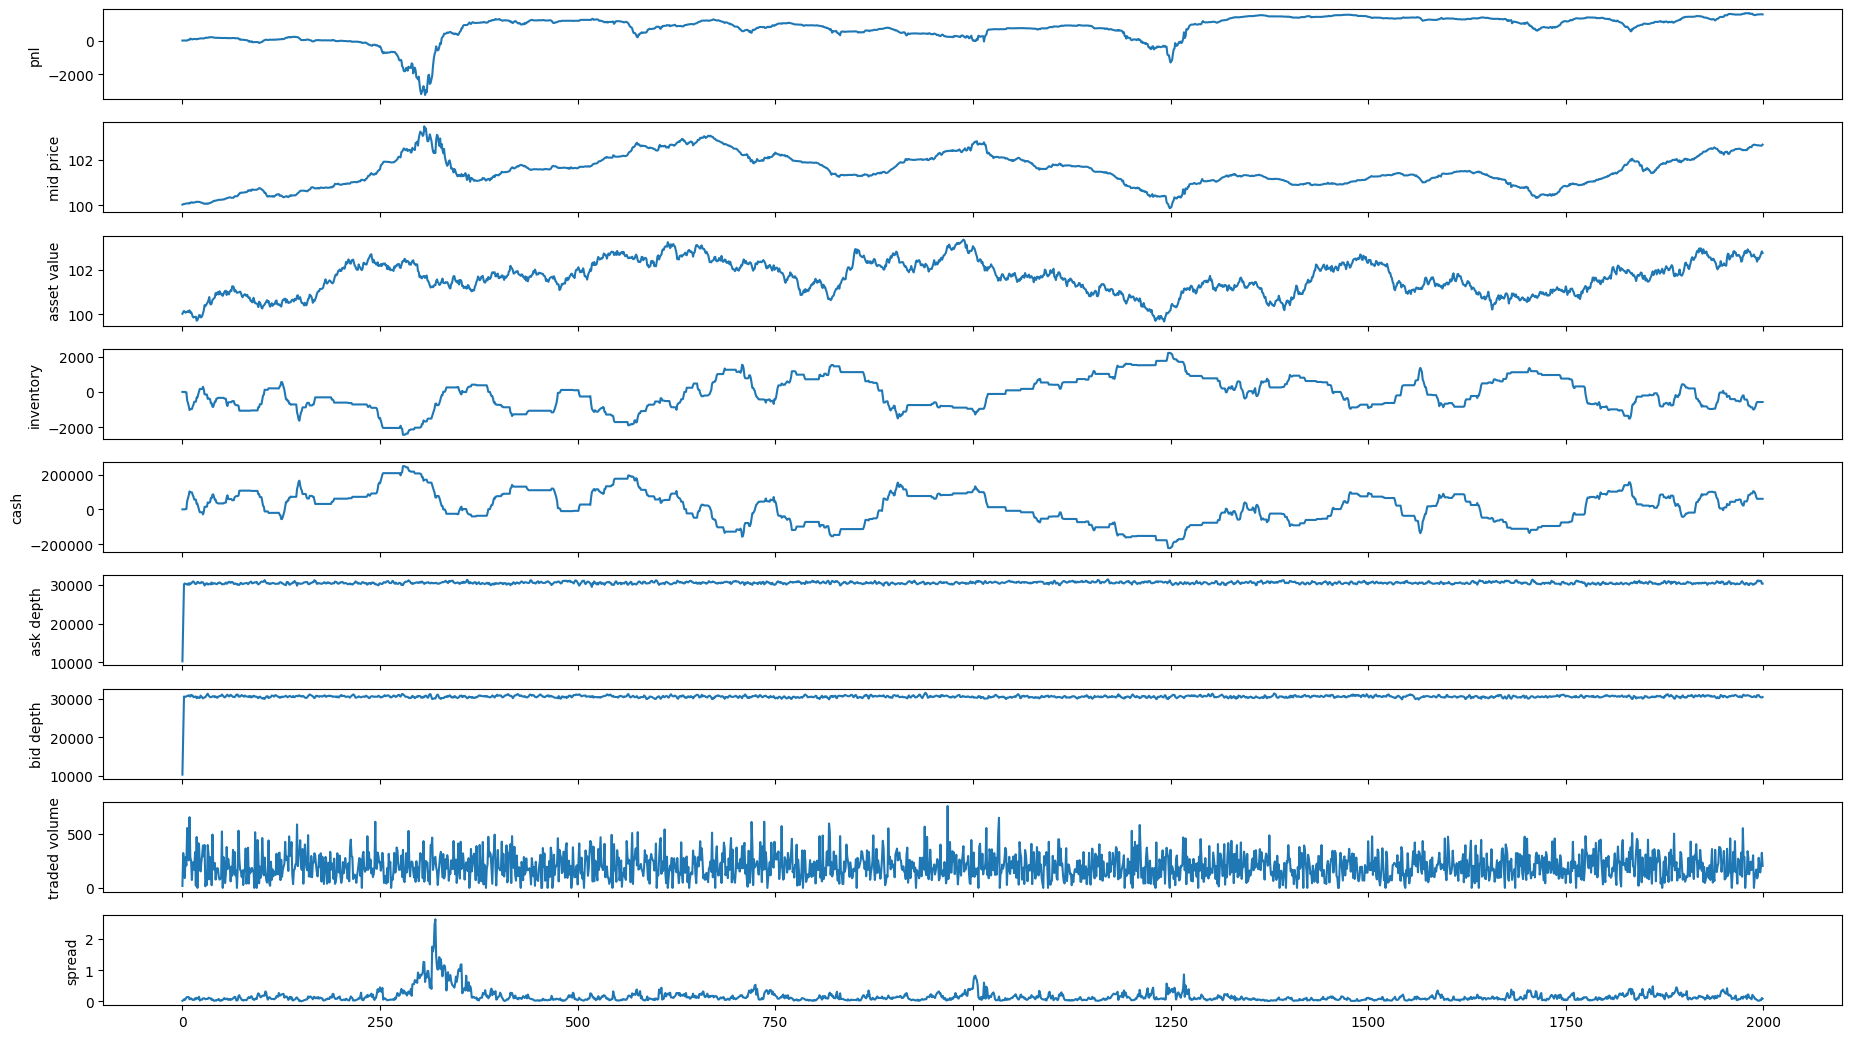

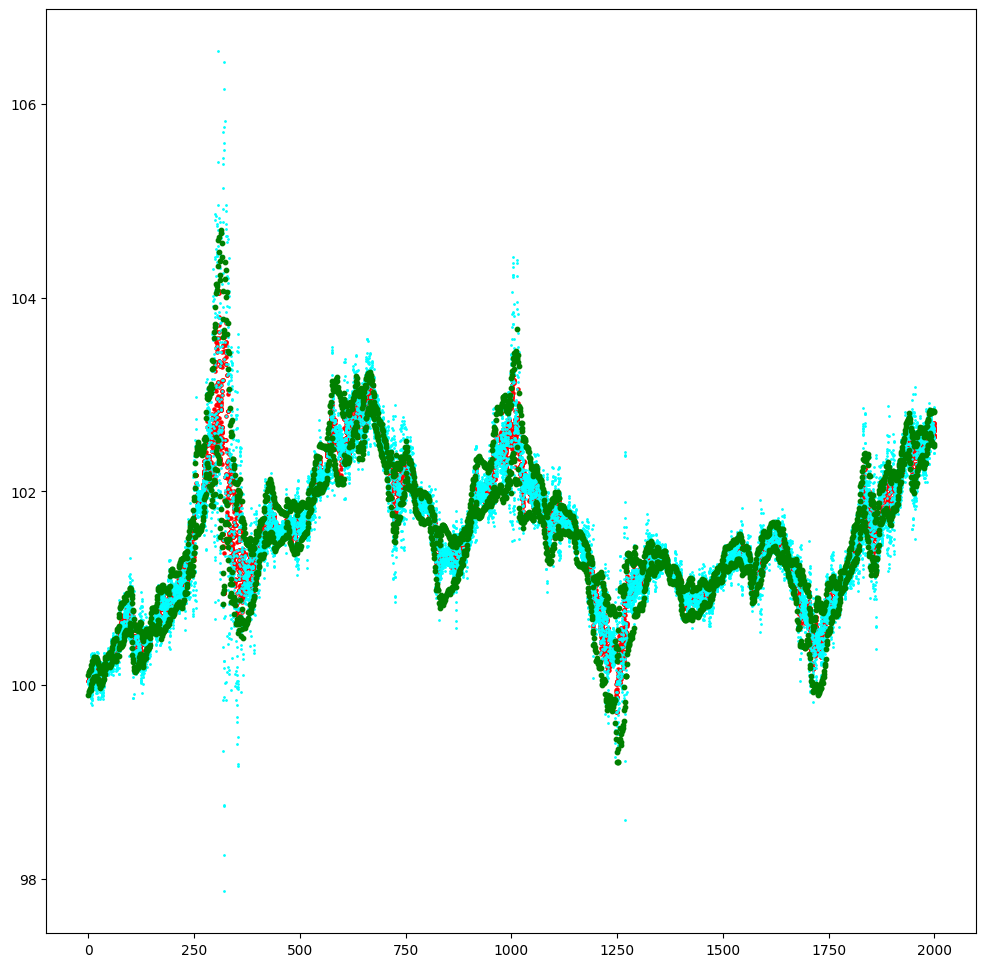

In [212]:
rng = np.random.default_rng(seed=42)
s = Asset()
ob = OrderBook()

mmStrat = SkewMarketMakingStrategy(10_000, 5_000_000, base_spread = 0.2, risk_aversion=0.1)
mm = MarketMaker(mmStrat)
bf = BackgroundFlow(arrival_rate = 12, info=0.2, ag_noise=0.1, private_info_coeff=0.9)

timesteps = 2000

# Visualise orders 
mm_orders = []
noise_orders = []
trade_prices = []

def simulate(mm, bf, ob, timesteps, asset):
    trackers = {
    "pnl" : np.zeros(timesteps),
    "mid price": np.zeros(timesteps),
    "asset value": np.zeros(timesteps),
    "inventory" : np.zeros(timesteps),
    "cash" : np.zeros(timesteps),
    "ask depth": np.zeros(timesteps),
    "bid depth": np.zeros(timesteps),
    "traded volume": np.zeros(timesteps),
    "spread": np.zeros(timesteps),
    }

    # cancellations are delayed. {delay: requests}
    delay = 2
    cancel_request = [[] for _ in range(delay+1)]

    for t in range(timesteps):
        # Price Moves 
        asset.evolve_value(drift=0, sigma=0.1)
        # Expiration Wheel advances
        expirations = ob.expiration_wheel.advance()
        # Expirations are processed 
        ob.process_cancellations(expirations)

        # All Actors place their orders 
        # Problem: cancellation can be shorter than shortest expiration time.
        quotes, cancellations = mm.order_update(ob)
        background_orders = bf.generate_orders(ob, asset)

        # Cancellations requested and processed
        now = t % (delay + 1)
        cancel_time = (t + delay) % (delay + 1)
        cancel_request[cancel_time] = cancellations
        ob.process_cancellations(cancel_request[now])
        cancel_request[now] = []

        # Visualise orders:
        mm_orders.append([quote.price for quote in quotes])
        noise_order_list = [order.price for order in background_orders if order.is_market == False]
        noise_orders.append(noise_order_list)

        # Orders are processed
        trades_notifs = ob.process_orders(chain(background_orders, quotes))
        trade_prices.append([notif.average_price for notif in trades_notifs.values()])

        
        # Process trade notifications for market maker 
        mm_trades_notifs = [trades_notif for _, trades_notif in trades_notifs.items() if trades_notif.trader_id == 1]
        mm.process_trades_notifications(mm_trades_notifs)

        # Calculate pnl
        pnl = mm.pnl_history[-1] if mm.pnl_history else 0

        # Track
        trackers["pnl"][t] = pnl
        trackers["mid price"][t] = ob.mid_price
        trackers["spread"][t] = ob.spread
        trackers["asset value"][t] = asset.value
        trackers["inventory"][t] = mm.inventory
        trackers["cash"][t] = mm.cash

        # Track Order Book Stats
        # Very Slow Call 
        ob_stats = ob.get_stats()
        trackers["ask depth"][t] = ob_stats["Ask Depth"]
        trackers["bid depth"][t] = ob_stats["Bid Depth"]
        trackers["traded volume"][t] = ob_stats["One Tick Traded Volume"]
        
    return trackers#, ob_stats

pr = cProfile.Profile()
pr.enable()
trackers = simulate(mm, bf, ob, timesteps, s)
pr.disable()

ps = pstats.Stats(pr).sort_stats('cumtime')
ps.print_stats(20)

fig, axes = plt.subplots(len(trackers), sharex=True)
for i, (k, v) in enumerate(trackers.items()):
    axes[i].plot(v)
    axes[i].set_ylabel(k)
fig.set_size_inches(18.5, 10.5)
fig.tight_layout()
fig.show()

fig2, ax2 = plt.subplots()
x = [[t]*len(orders_t) for t, orders_t in enumerate(mm_orders)]
y = mm_orders 
x_flat = [p for sublist in x for p in sublist]
y_flat = [p for sublist in y for p in sublist]

x2 = [[t]*len(orders_t) for t, orders_t in enumerate(noise_orders)]
y2 = noise_orders
x2_flat = [x for sublist in x2 for x in sublist]
y2_flat = [y for sublist in y2 for y in sublist]

x3 = [[t]*len(prices) for t, prices in enumerate(trade_prices)]
y3_flat = [y for sublist in trade_prices for y in sublist]
x3_flat = [x for sublist in x3 for x in sublist]

ax2.scatter(x3_flat, y3_flat, s=5, color='red')
ax2.scatter(x2_flat, y2_flat, s=1, color='cyan')
ax2.scatter(x_flat, y_flat, s=10, color='g')

fig2.set_size_inches(12,12)

In [56]:
n_market_makers = 10
market_makers = []
for i in range(1,n_market_makers+1):
    risk_aversion = rng.random()
    capital = 2**rng.integers(15,23)
    profile = MarketMakerProfile(risk_aversion, capital)
    params = profile.get_strategy_params()
    skew_strat = SkewMarketMakingStrategy(params["spread"], params["size"], params["inventory_limit"], params["skew_coefficient"])
    mm = MarketMaker(skew_strat)
    mm.trader_id = i
    market_makers.append(mm)

# some rough math: average capital ~ 2^19 ~ $500,000 
# average quote size: 1.5% capital / average asset price ~ 75
# average depth: 10 * 75 = 750 

# background orders — average size 55
# random limit orders ~ 50% of background flow
# market orders weighted fraction of orders: 55 * lambda * 0.5; lambda is the arrival rate.
# If we aim for around 30% market orders: lambda ~ 37 

0 11.198377055260892
0 298.8937339698068
0 81.92290452930995
0 43.98498444562236
0 11.198377055260892
0 24.80162294473911
0 11.198377055260892
0 81.92290452930995
0 24.710372468923552
0 19.18336150088325
0 43.98498444562236
0 11.198377055260892
0 116.68120190942041
0 57.212532060386394
0 81.92290452930995
0 43.98498444562236
0 11.198377055260892
0 74.81663849911675
0 43.98498444562236
0 11.198377055260892
0 82.7874679396136
0 7.106266030193197
0 81.92290452930995
0 43.98498444562236
0 11.198377055260892
0 49.8937339698068
0 81.92290452930995
0 43.98498444562236
0 11.198377055260892
0 181.89373396980682
0 81.92290452930995
0 43.98498444562236
0 11.198377055260892
0 68.8937339698068
0 81.92290452930995
0 43.98498444562236
0 11.198377055260892
0 221.89373396980682
0 81.92290452930995
0 43.98498444562236
0 11.198377055260892
0 26.80162294473911
0 11.198377055260892
0 81.92290452930995
0 72.71037246892355
0 17.18336150088325
0 43.98498444562236
0 11.198377055260892
0 293.6812019094204
0 9.2

/var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_60023/2531563378.py:126: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


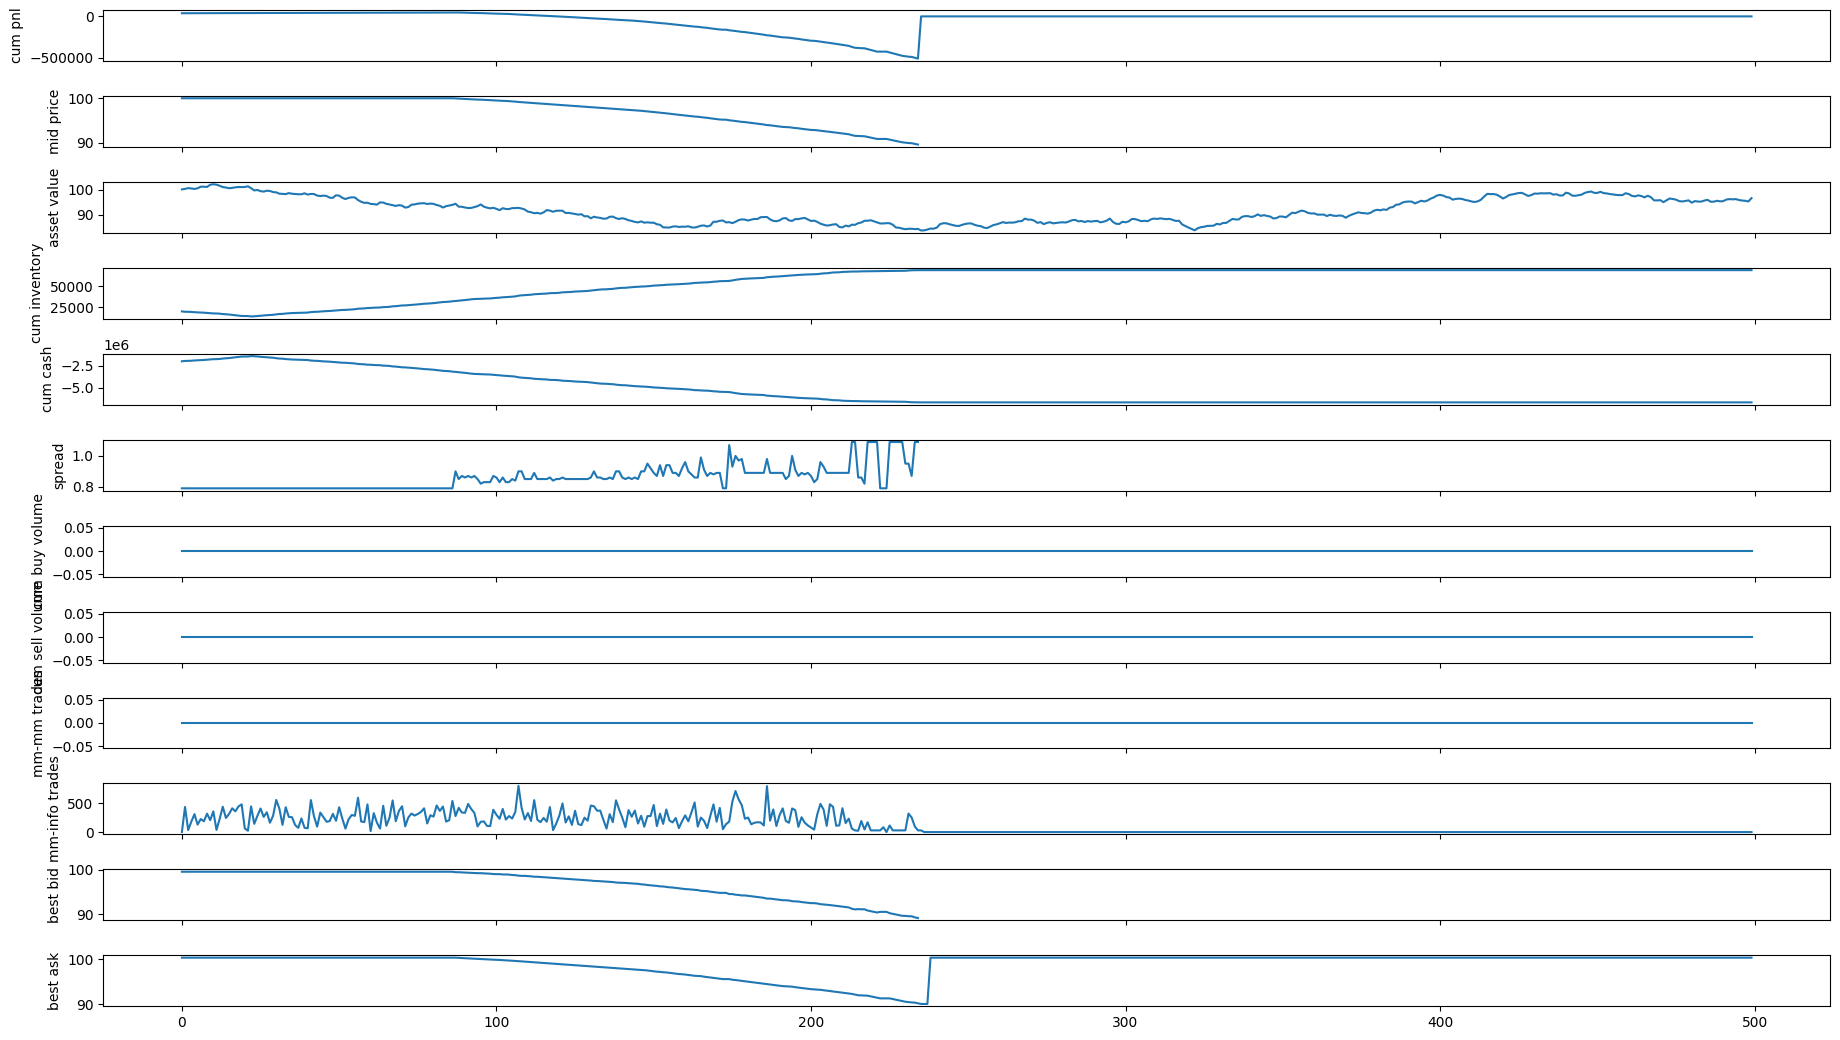

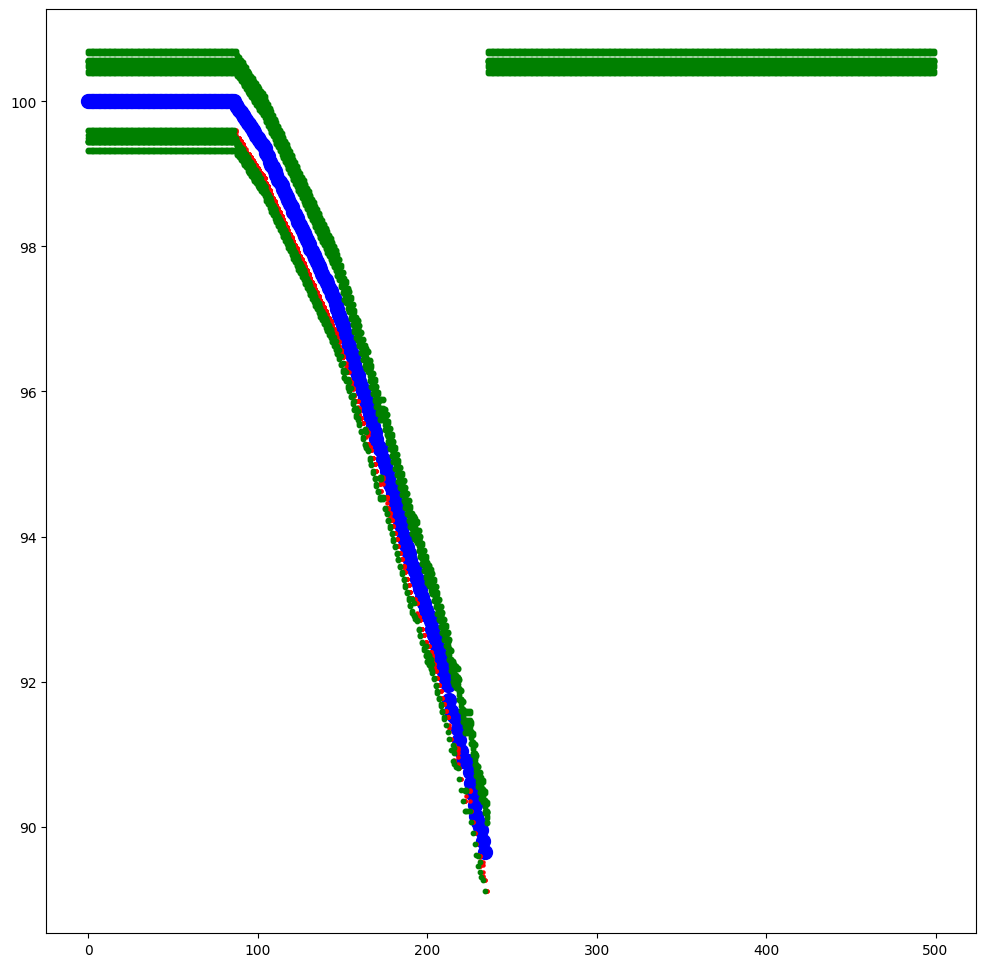

In [60]:
rng = np.random.default_rng(seed=42)
s = Asset()
ob = OrderBook()

bf = BackgroundFlow(arrival_rate = 5, info=1, ag_noise=0, private_info_coeff=1)
timesteps = 500

# Visualise orders 
mm_orders = []
noise_orders = []
trade_prices = []

def simulate(mm, bf, ob, timesteps, asset):
    trackers = {
    "cum pnl" : np.zeros(timesteps),
    "mid price": np.zeros(timesteps),
    "asset value": np.zeros(timesteps),
    "cum inventory" : np.zeros(timesteps),
    "cum cash" : np.zeros(timesteps),
    "spread": np.zeros(timesteps),
    "cum buy volume": np.zeros(timesteps),
    "cum sell volume": np.zeros(timesteps),
    "mm-mm trades": np.zeros(timesteps),
    "mm-info trades": np.zeros(timesteps),
    "best bid": np.zeros(timesteps),
    "best ask": np.zeros(timesteps)
    }

    # cancellations are delayed. {delay: requests}
    delay = 3
    cancel_request = [[] for _ in range(delay+1)]

    for t in range(timesteps):
        # Price Moves 
        asset.evolve_value(drift=0)
        # Expiration Wheel advances
        expirations = ob.expiration_wheel.advance()
        # Expirations are processed 
        ob.process_cancellations(expirations)

        # All Actors place their orders 
        # Problem: cancellation can be shorter than shortest expiration time.
        mm_quotes = []
        mm_cancellations = []
        for market_maker in market_makers:
            quotes, cancellations = market_maker.order_update(ob)
            mm_quotes.extend(quotes)
            mm_cancellations.extend(cancellations)
        background_orders = bf.generate_orders(ob, asset)

        # Cancellations requested and processed
        now = t % (delay + 1)
        cancel_time = (t + delay) % (delay + 1)
        cancel_request[cancel_time] = cancellations
        ob.process_cancellations(cancel_request[now])
        cancel_request[now] = []

        # Visualise orders:
        mm_orders.append([quote.price for quote in mm_quotes])
        noise_order_list = [order.price for order in background_orders if order.is_market == False]
        noise_orders.append(noise_order_list)

        # Orders are processed
        trades_notifs = ob.process_orders(chain(background_orders, mm_quotes))
        trade_prices.append([notif.average_price for notif in trades_notifs.values()])

        
        # Process trade notifications for market maker 
        cum_pnl = 0 
        cum_inventory = 0
        cum_cash = 0
        mm_mm_trade_volume = 0 
        mm_info_trade_volume = 0
        for market_maker in market_makers:
            mm_trades_notifs = [trades_notif for _ , trades_notif in trades_notifs.items() if trades_notif.trader_id == market_maker.trader_id]
            market_maker.process_trades_notifications(mm_trades_notifs)
            pnl = market_maker.pnl(ob)
            cum_pnl += pnl if pnl else 0
            cum_inventory += market_maker.inventory
            cum_cash += market_maker.cash
            market_maker.buy_volume = 0 
            market_maker.sell_volume = 0 
            for notif in mm_trades_notifs:
                for k,v in notif.counter_party_volume.items():
                    print(k, v)
                    if k >=1:
                        mm_mm_trade_volume += v
                    else:
                        mm_info_trade_volume += v

        # Track
        trackers["cum pnl"][t] = cum_pnl
        trackers["mid price"][t] = ob.mid_price
        trackers["spread"][t] = ob.spread
        trackers["asset value"][t] = asset.value
        trackers["cum inventory"][t] = cum_inventory
        trackers["cum cash"][t] = cum_cash
        trackers["mm-mm trades"][t] = mm_mm_trade_volume
        trackers["mm-info trades"][t] = mm_info_trade_volume
        trackers["best bid"][t] = ob.best_bid
        trackers["best ask"][t] = ob.best_ask

        # Track Order Book Stats
        # Very Slow Call 
        # ob_stats = ob.get_stats()
        # trackers["ask depth"][t] = ob_stats["Ask Depth"]
        # trackers["bid depth"][t] = ob_stats["Bid Depth"]
        # trackers["traded volume"][t] = ob_stats["One Tick Traded Volume"]
        
    return trackers

pr = cProfile.Profile()
pr.enable()
trackers = simulate(mm, bf, ob, timesteps, s)
pr.disable()

ps = pstats.Stats(pr).sort_stats('cumtime')
ps.print_stats(20)

fig, axes = plt.subplots(len(trackers), sharex=True)
for i, (k, v) in enumerate(trackers.items()):
    axes[i].plot(v)
    axes[i].set_ylabel(k)
fig.set_size_inches(18.5, 10.5)
fig.tight_layout()
fig.show()

fig2, ax2 = plt.subplots()
x = [[t]*len(orders_t) for t, orders_t in enumerate(mm_orders)]
y = mm_orders 
x_flat = [p for sublist in x for p in sublist]
y_flat = [p for sublist in y for p in sublist]

x2 = [[t]*len(orders_t) for t, orders_t in enumerate(noise_orders)]
y2 = noise_orders
x2_flat = [x for sublist in x2 for x in sublist]
y2_flat = [y for sublist in y2 for y in sublist]

x3 = [[t]*len(prices) for t, prices in enumerate(trade_prices)]
y3_flat = [y for sublist in trade_prices for y in sublist]
x3_flat = [x for sublist in x3 for x in sublist]

ax2.scatter([[t] for t in range(timesteps)],trackers["mid price"], s=100, color="blue")

ax2.scatter(x3_flat, y3_flat, s=5, color='red')
ax2.scatter(x2_flat, y2_flat, s=1, color='cyan')
ax2.scatter(x_flat, y_flat, s=10, color='g')

fig2.set_size_inches(12,12)